In [11]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from betavae import BetaVAE, compile_vae, extract_latent_dimensions, weights
from optimize_utils import get_optimizer

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [12]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [13]:
# Load the best hyperparameters
study_name = "BetaVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [14]:
#Initialize the model and optimizer
model = BetaVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

Epoch 1, Train Loss: 188.24456477378732, Val Loss: 224.2914021809896, Test Loss: 245.11972384982639
Epoch 2, Train Loss: 158.62412109375, Val Loss: 163.49256727430554, Test Loss: 180.81932915581598
Epoch 3, Train Loss: 148.98916744402985, Val Loss: 262.2269287109375, Test Loss: 291.9794921875
Epoch 4, Train Loss: 147.22067688899253, Val Loss: 139.96576605902777, Test Loss: 140.19178602430554
Epoch 5, Train Loss: 133.28223457905784, Val Loss: 129.18115912543402, Test Loss: 135.36448838975696
Epoch 6, Train Loss: 129.37854696245336, Val Loss: 113.52520751953125, Test Loss: 118.80350070529514
Epoch 7, Train Loss: 124.6286963619403, Val Loss: 97.37888590494792, Test Loss: 105.00303819444444
Epoch 8, Train Loss: 117.3558542735541, Val Loss: 102.60636054144965, Test Loss: 107.7886725531684
Epoch 9, Train Loss: 112.57267811333955, Val Loss: 96.69134521484375, Test Loss: 102.25003051757812
Epoch 10, Train Loss: 107.1381005130597, Val Loss: 101.38549465603299, Test Loss: 114.72684733072917
Epoc

In [15]:
# Save the model
model_path = pathlib.Path("results/best_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [16]:
# Save training history
history = {
    'loss' : train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

history_path = pathlib.Path("results/training_history_layers.json")
with open(history_path, 'w') as f:
    json.dump(history, f)

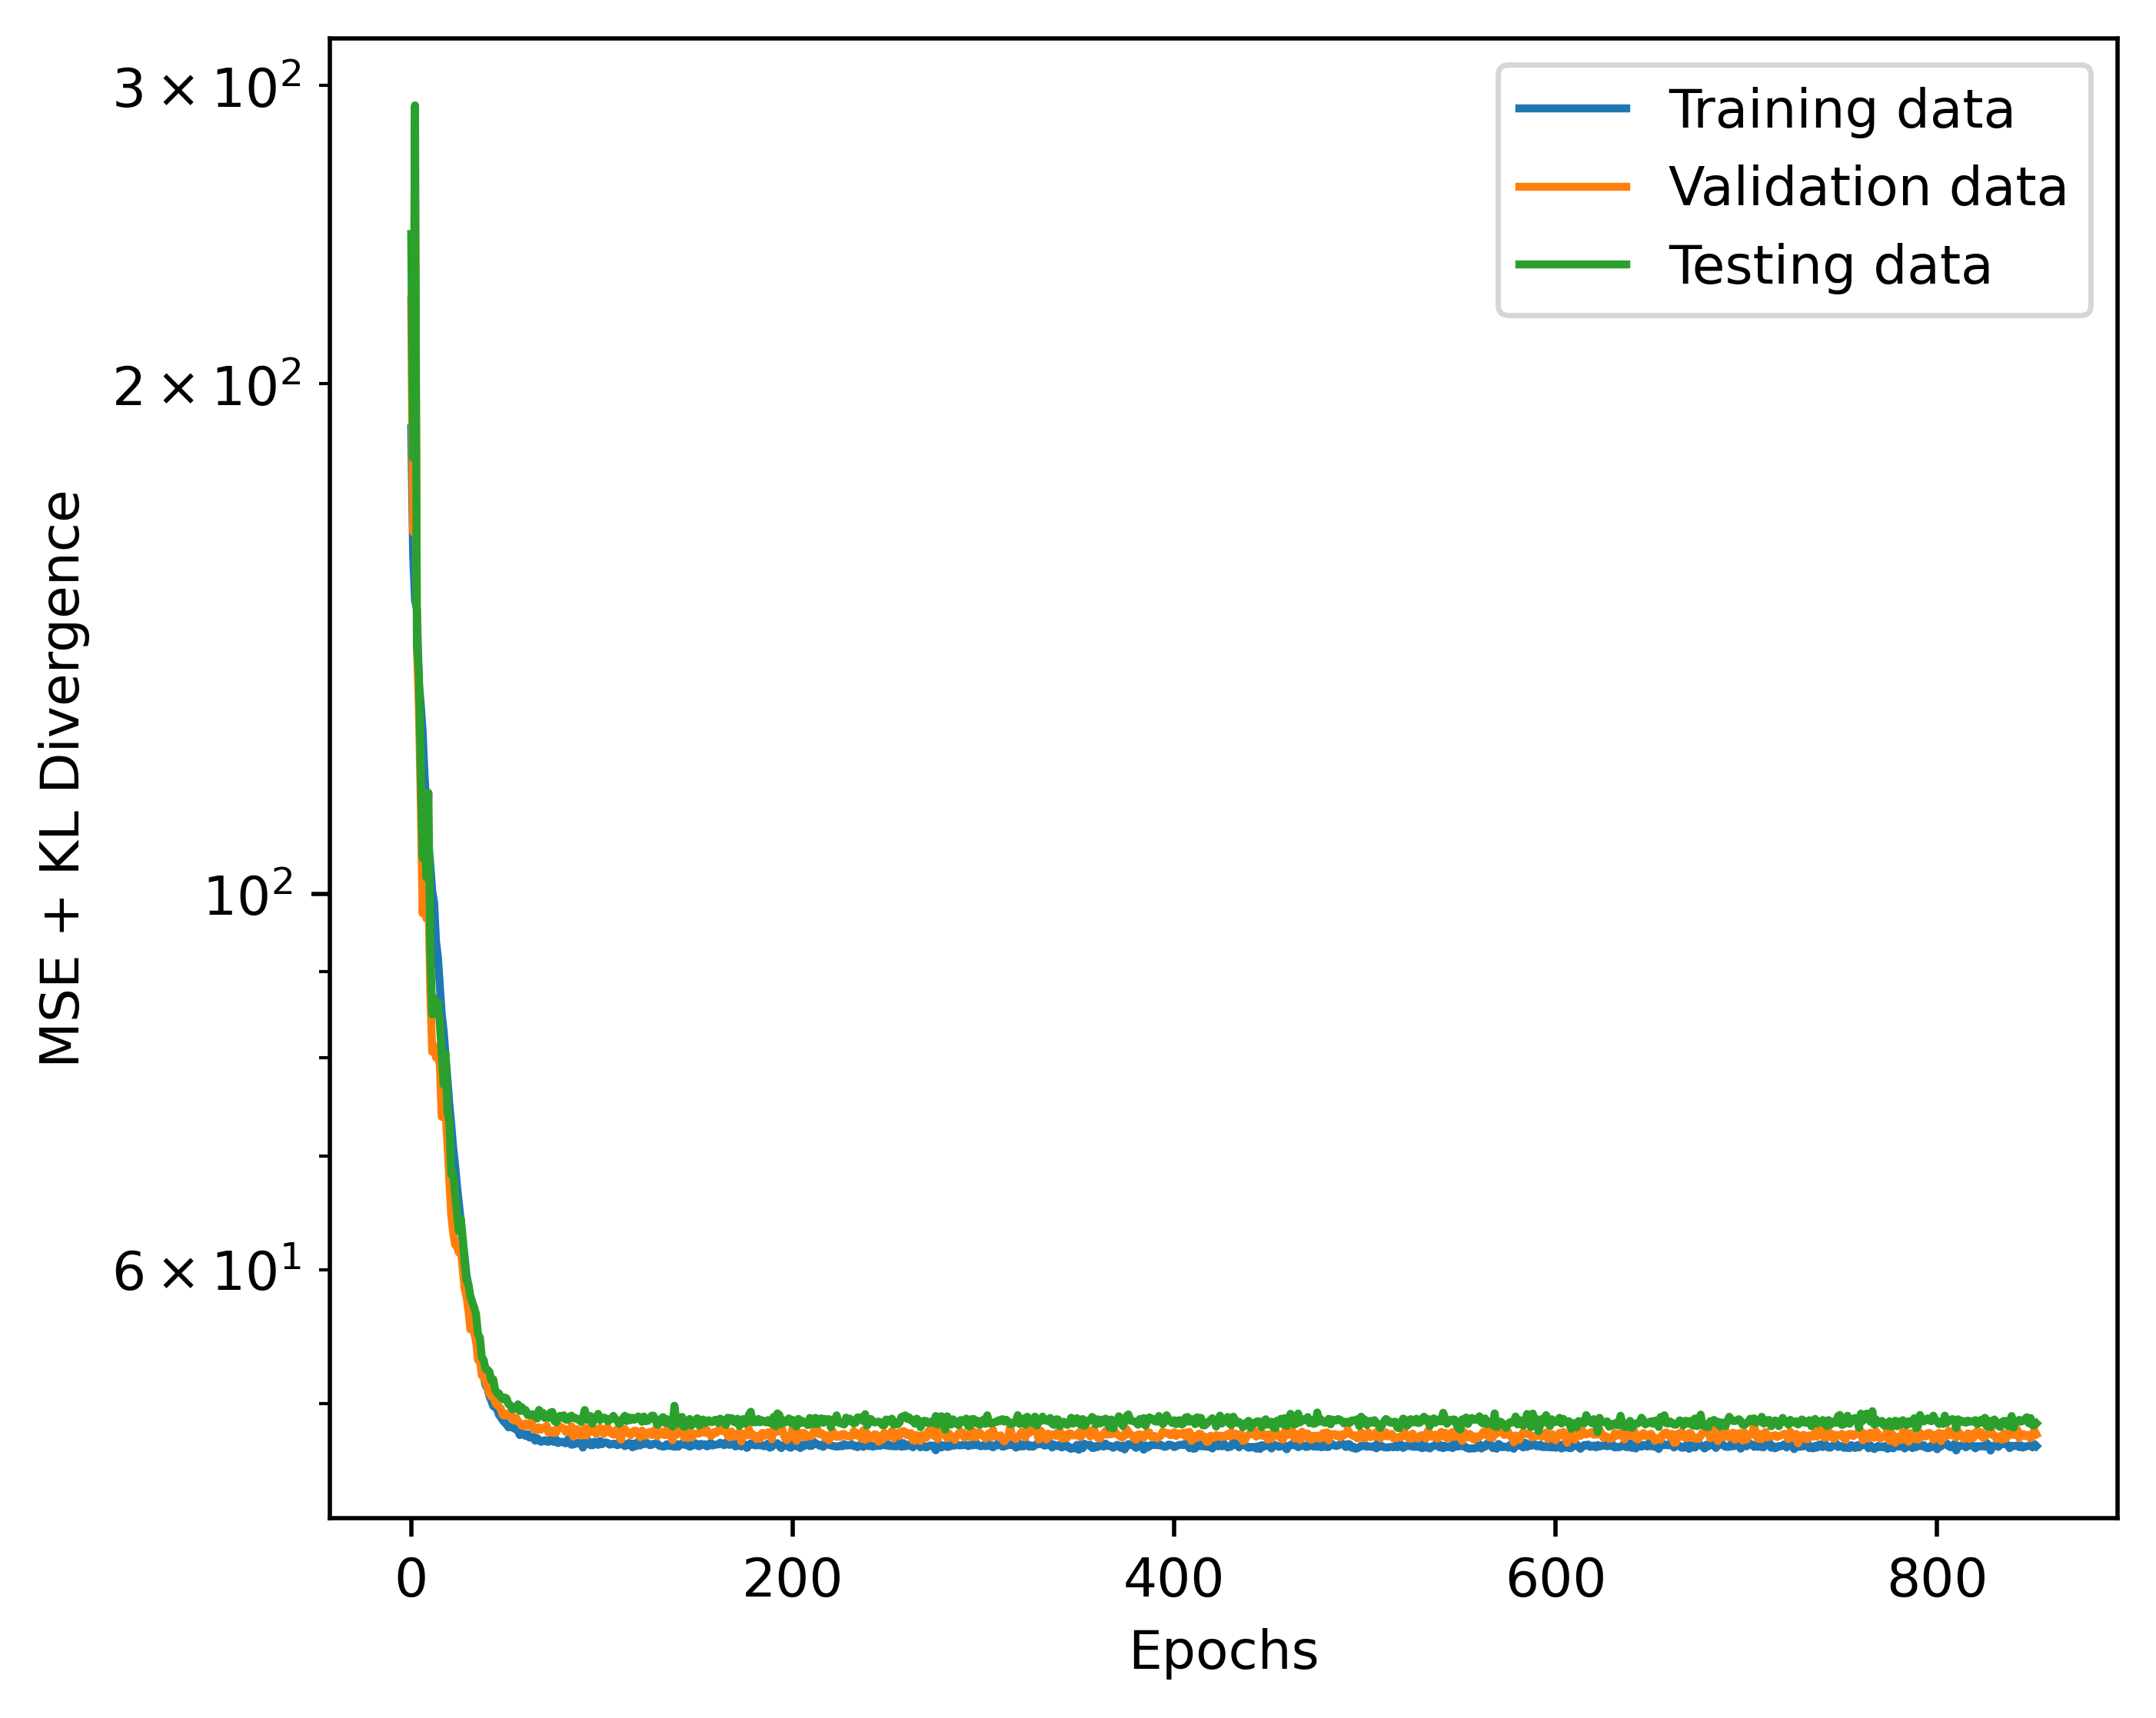

In [17]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(train_loss_history, label="Training data")
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

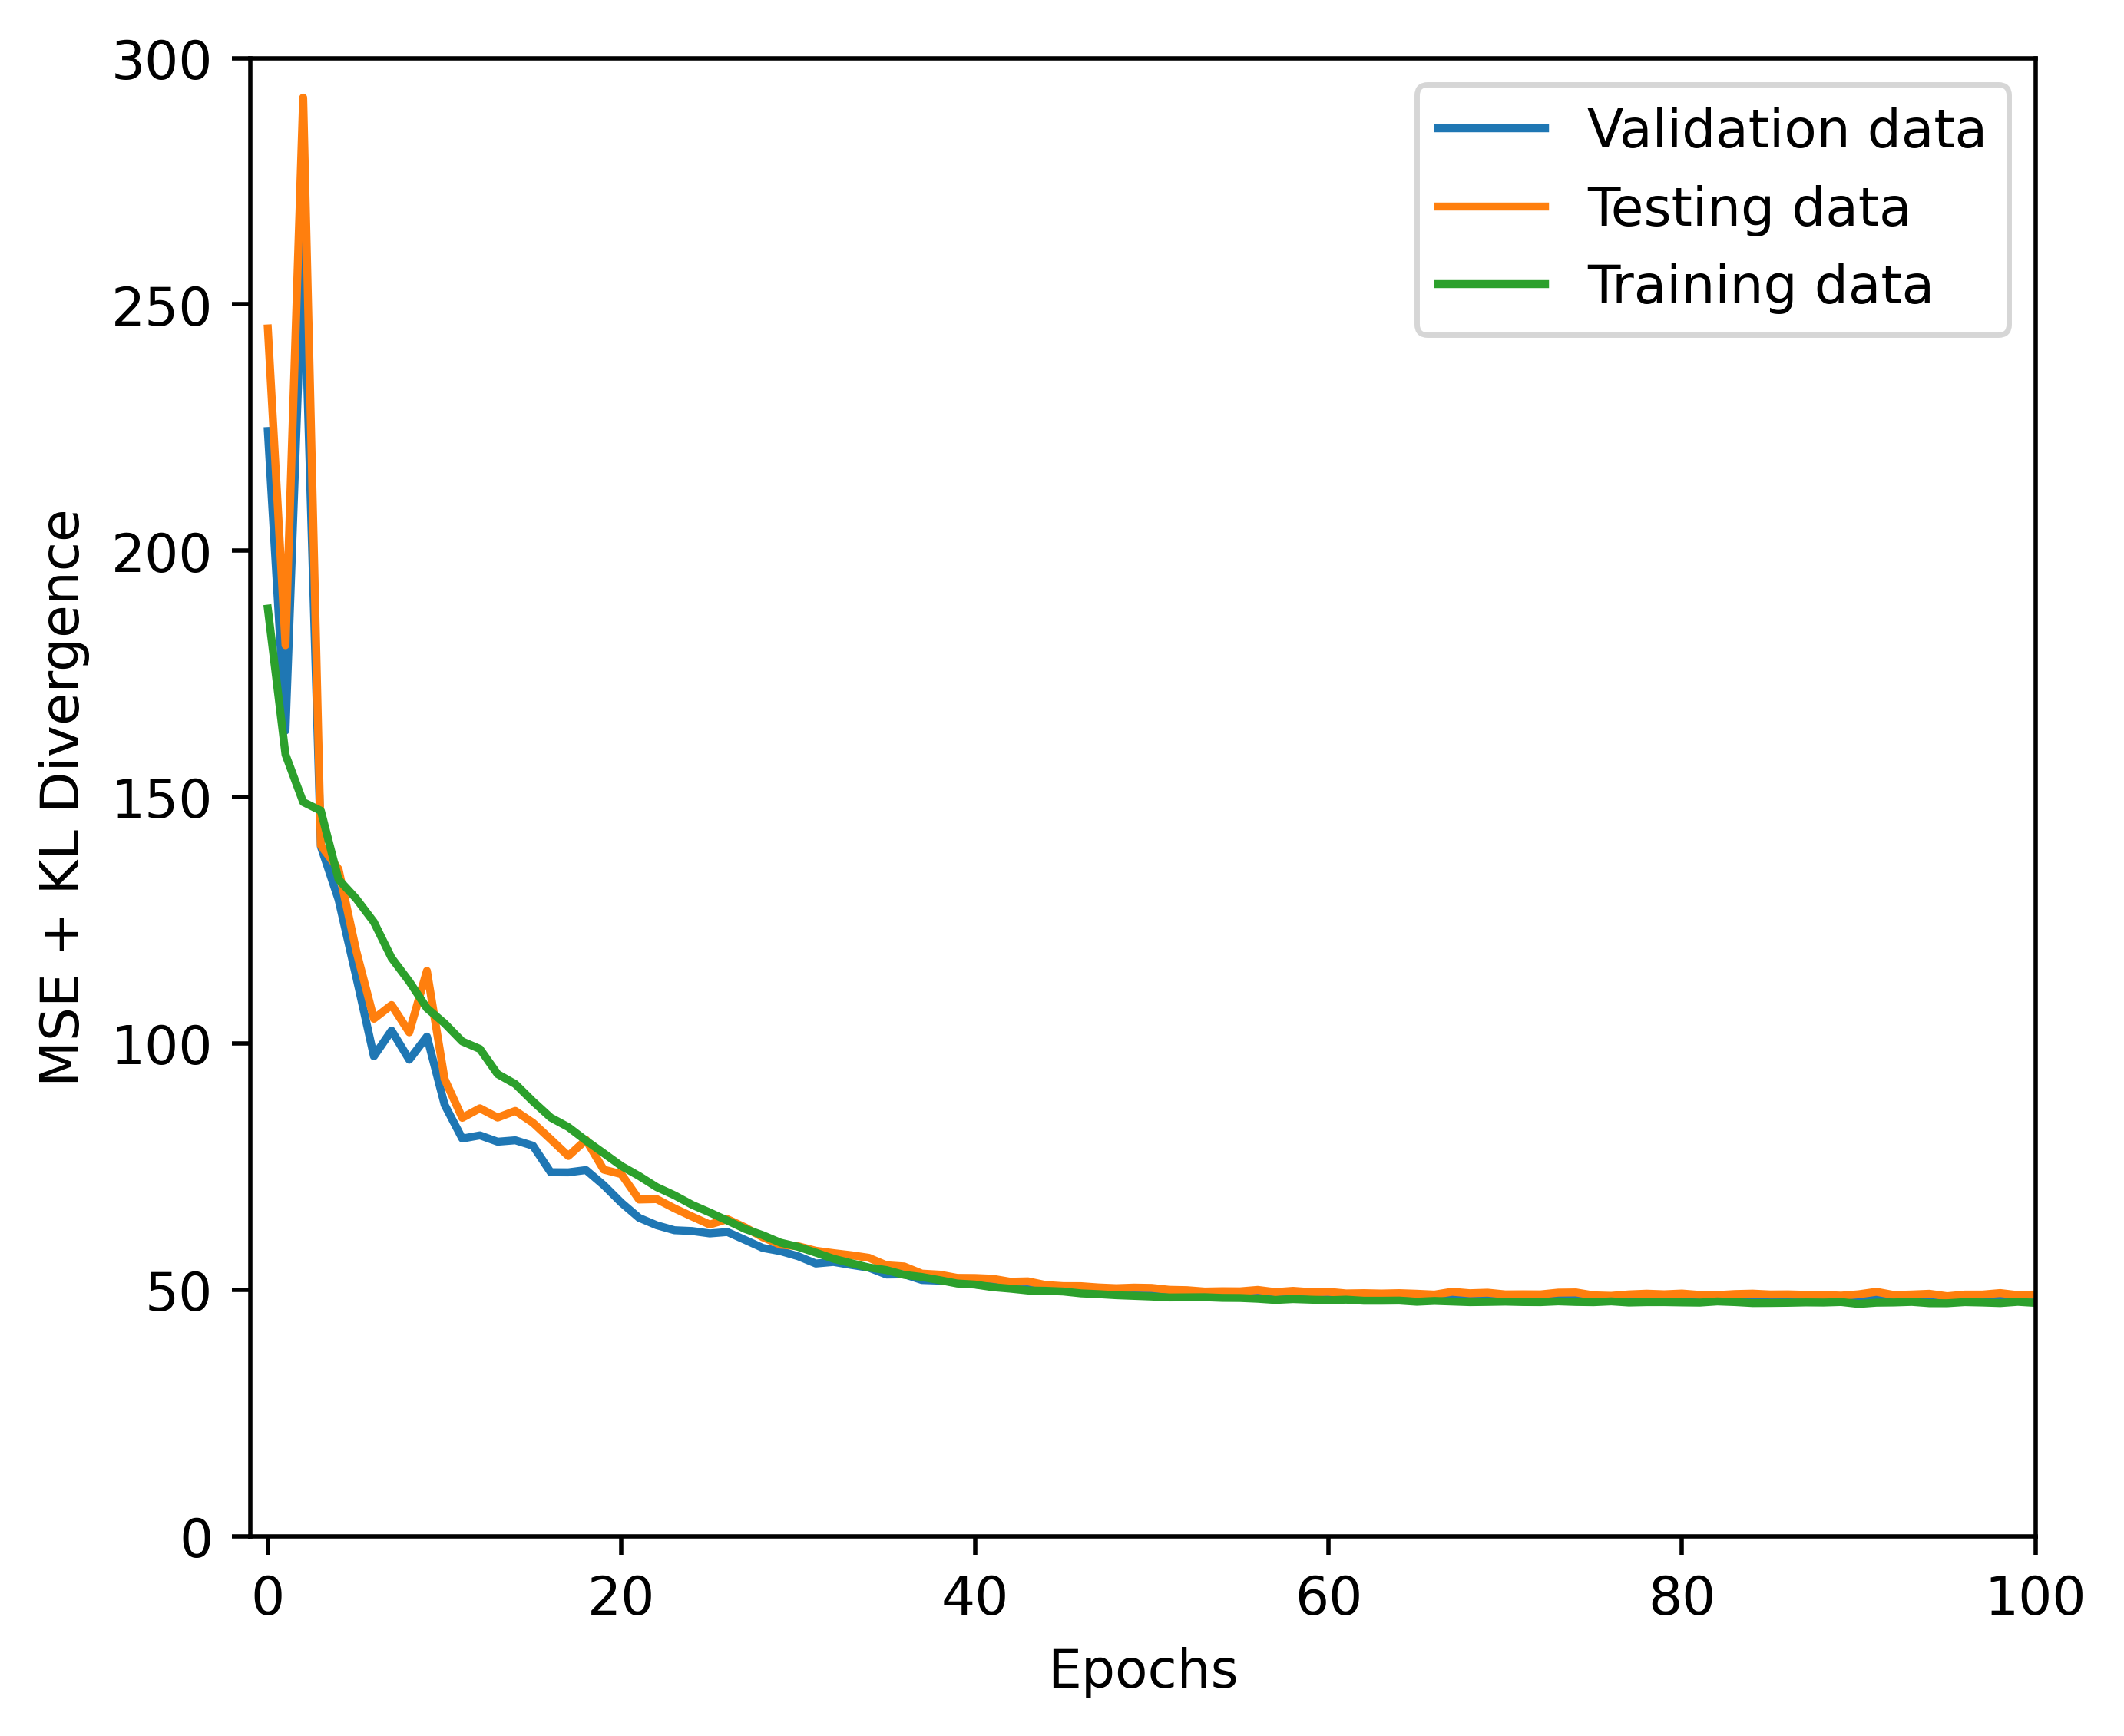

In [23]:
save_path = pathlib.Path("../1.data-exploration/figures/training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,100)
plt.ylim(0,300)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [19]:
# Extract the latent space dimensions
metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.parquet")
metadata = pd.read_parquet(metadata_df_dir)

train_and_test_subbed_dir = pathlib.Path("../0.data-download/data/train_and_test_subbed.parquet")
train_and_test_subbed = pd.read_parquet(train_and_test_subbed_dir)


# Convert DataFrame to NumPy and then Tensor
train_test_array = train_and_test_subbed.to_numpy()
train_test_tensor = torch.tensor(train_test_array, dtype=torch.float32)

#Create TensorDataset and DataLoader
tensor_dataset = TensorDataset(train_test_tensor)
train_and_test_subbed_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)

latent_df = extract_latent_dimensions(model, train_and_test_subbed_loader, metadata)
print(latent_df.head())

      ModelID         0         1    2         3         4    5    6  \
0  ACH-000361  3.530525  4.156108  0.0  1.601140  2.414286  0.0  0.0   
1  ACH-000976  3.086076  3.184597  0.0  0.967036  2.675261  0.0  0.0   
2  ACH-000279  4.452415  5.222219  0.0  2.702778  3.707901  0.0  0.0   
3  ACH-000515  3.673387  4.184433  0.0  1.921372  3.763193  0.0  0.0   
4  ACH-001523  4.453293  5.338490  0.0  2.542519  2.574579  0.0  0.0   

          7         8         9        10  
0  1.538892  0.000000  4.102537  5.569394  
1  1.675283  0.066381  3.905764  4.311126  
2  1.617848  1.200789  5.000596  7.676916  
3  1.457456  1.540911  4.342864  6.062133  
4  2.116240  0.000000  4.998771  6.608235  


In [20]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train"
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = weights(model, train_data)